In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist


from utils import geometry
from utils import fileio

In [29]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/green_edges/tm_edges.csv', skiprows=[1,2,3])

In [30]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_*/*/Data/*_cell_data_geometry.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots\\20240117_2_IP_GFPCAAX-CheHis_uu_0p5/'

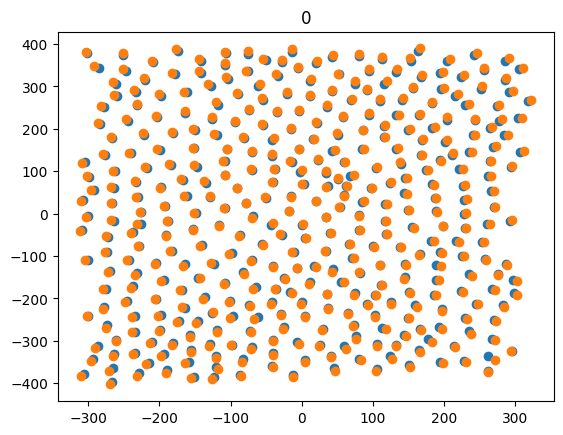

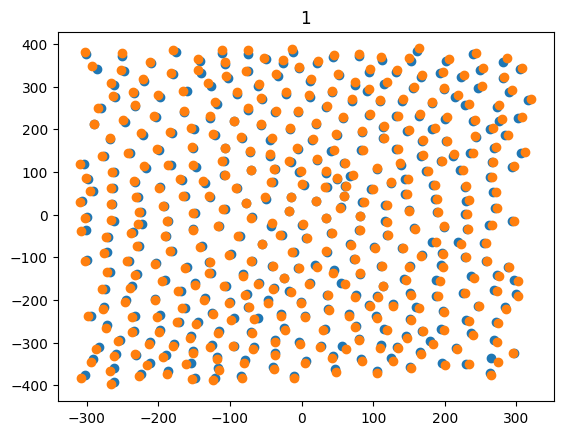

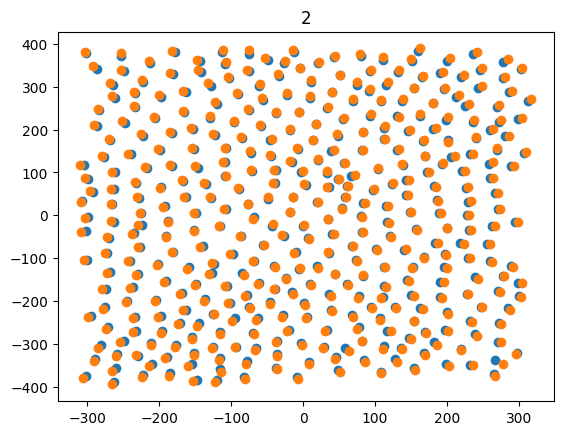

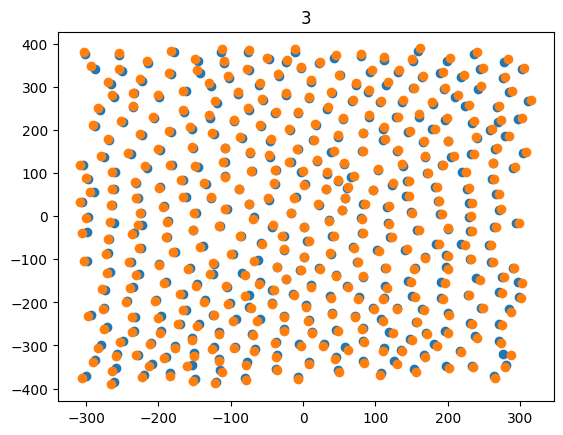

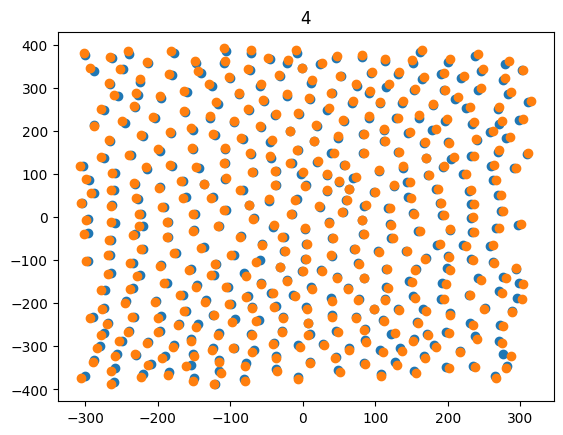

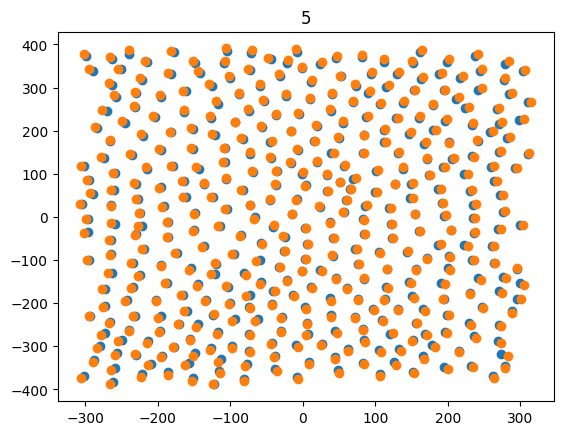

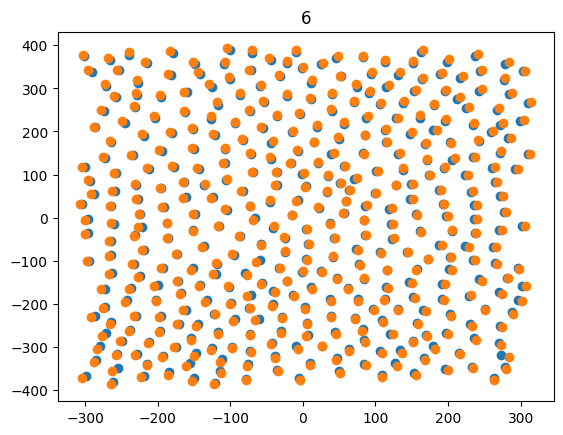

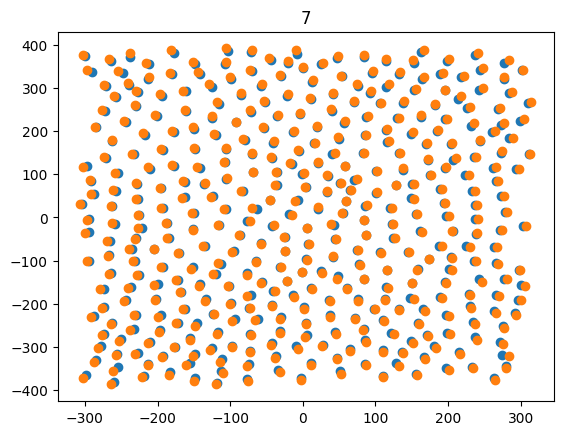

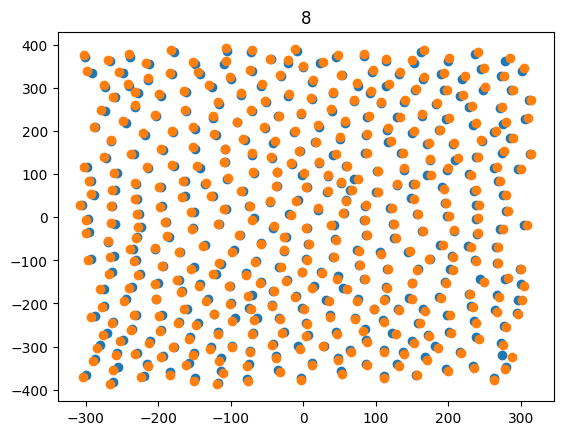

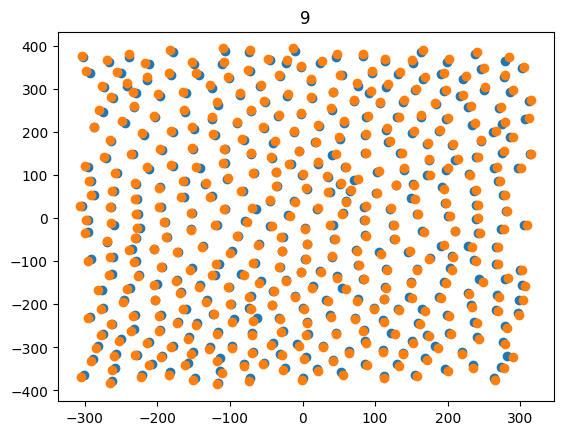

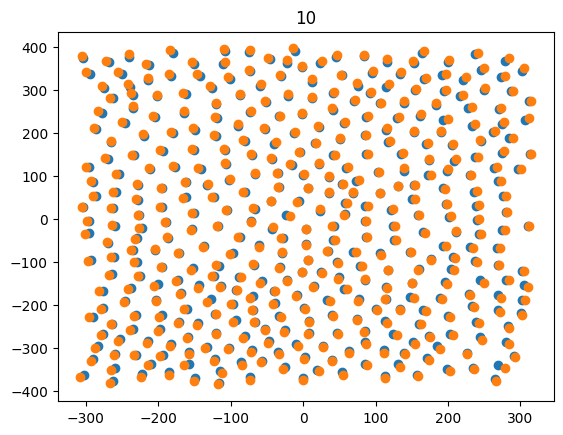

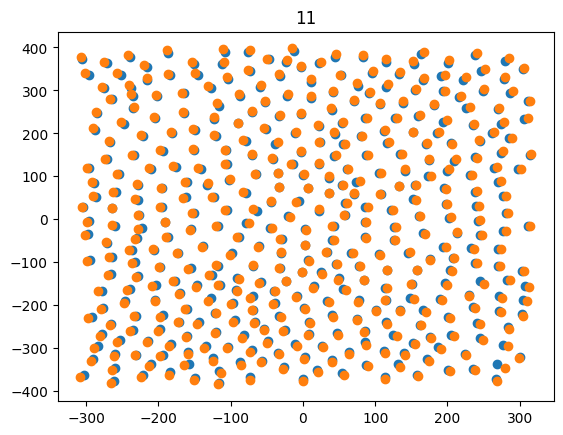

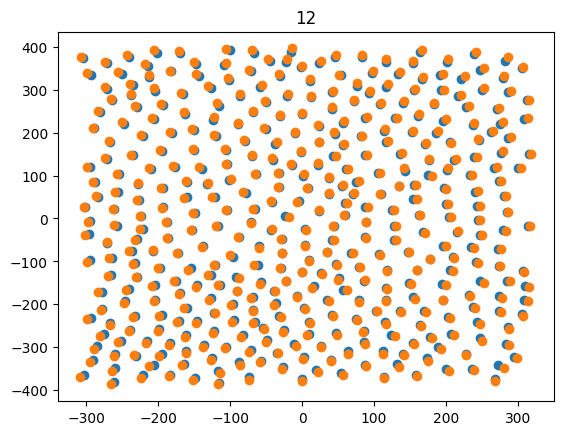

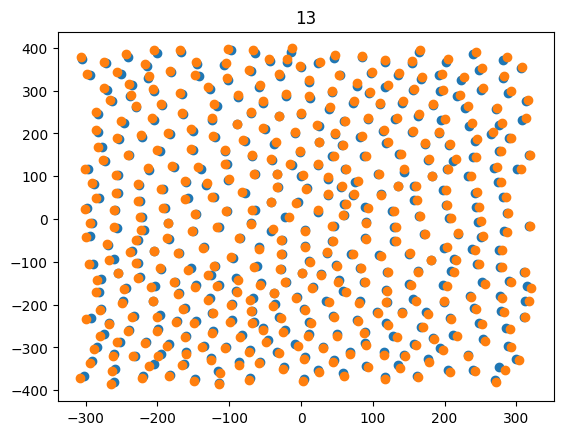

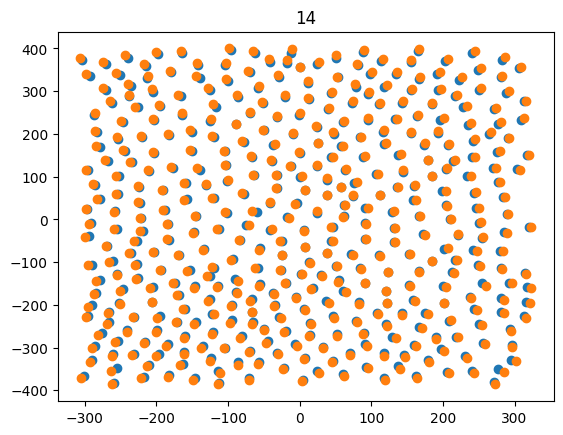

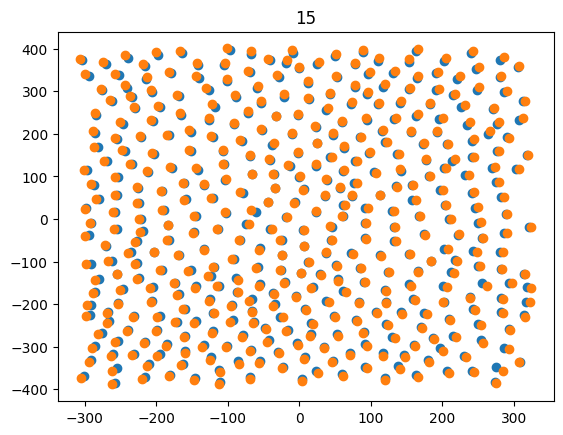

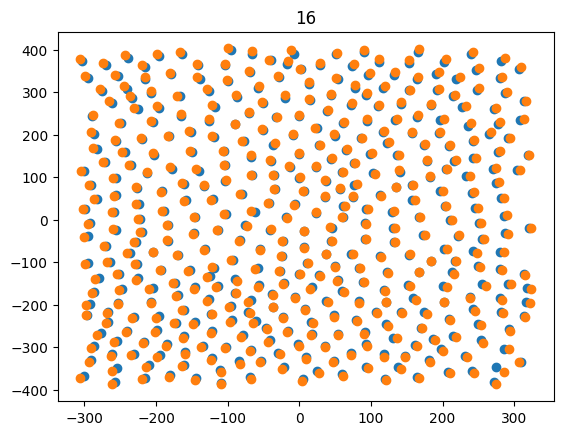

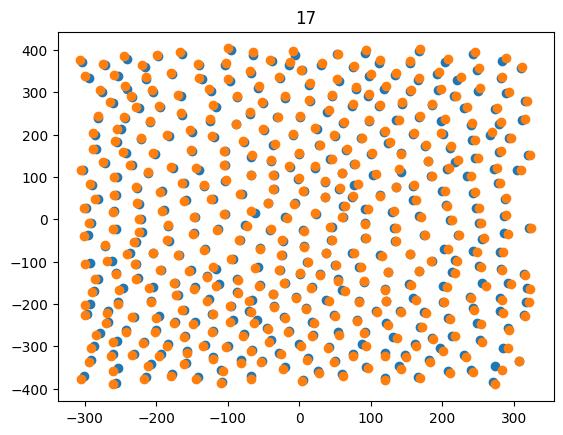

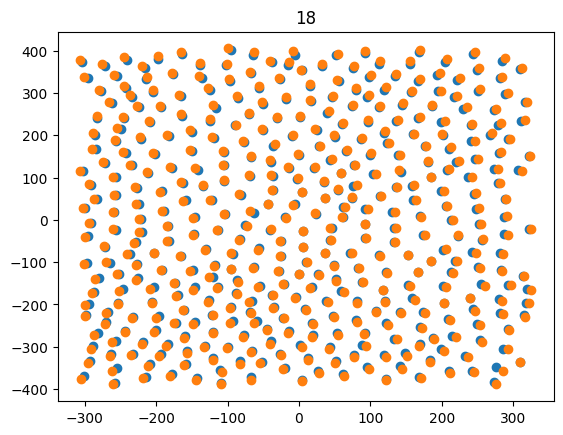

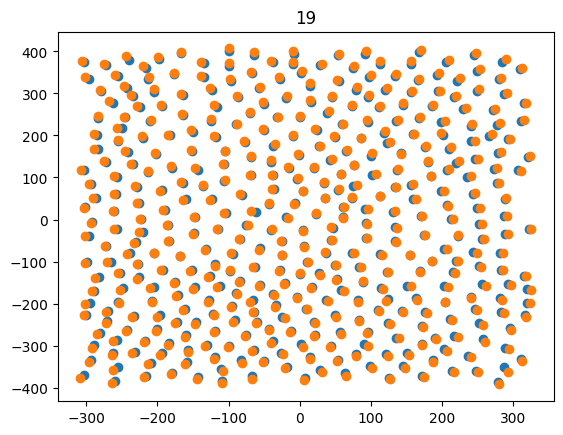

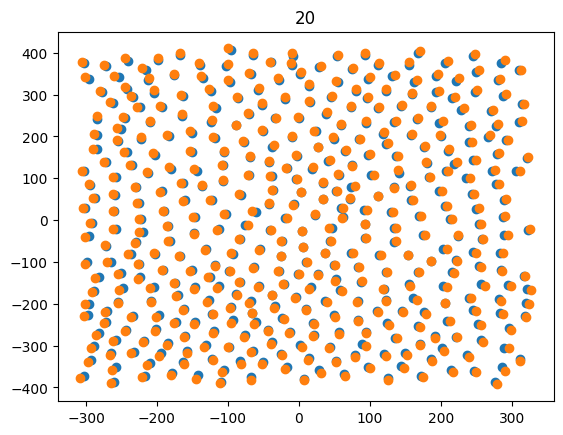

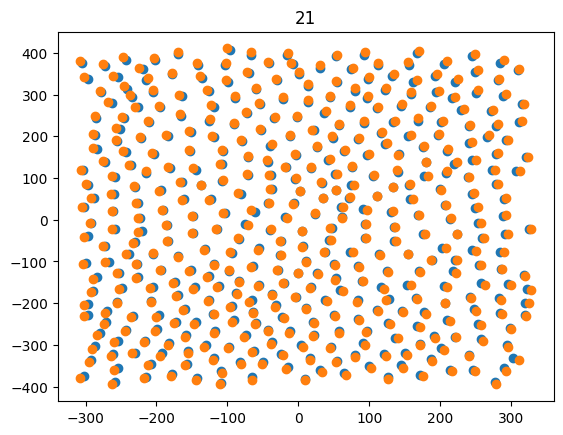

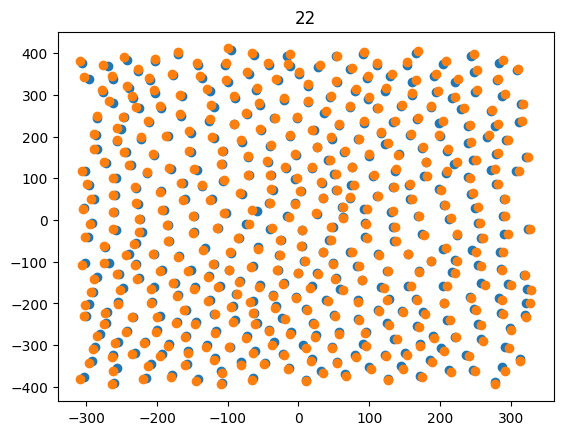

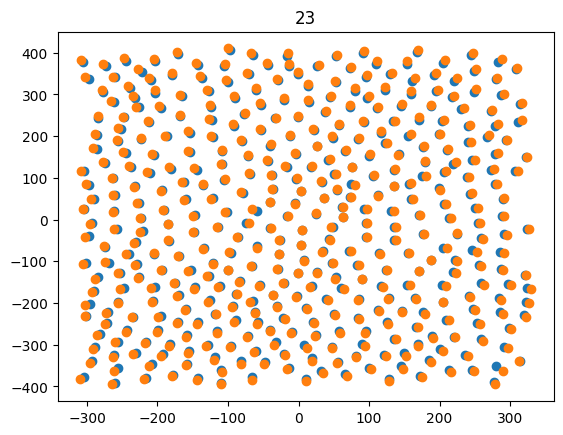

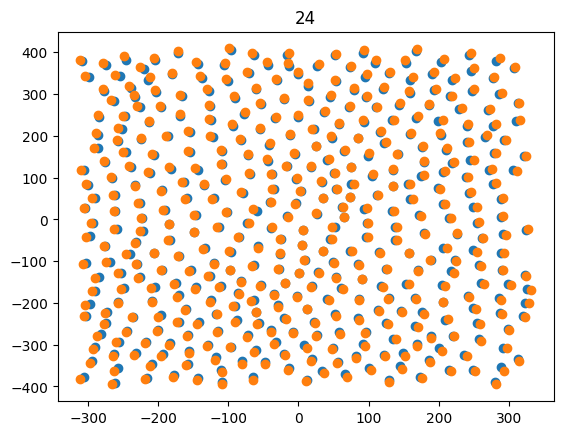

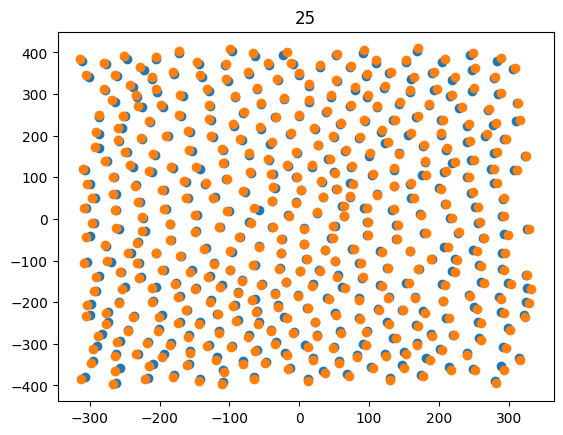

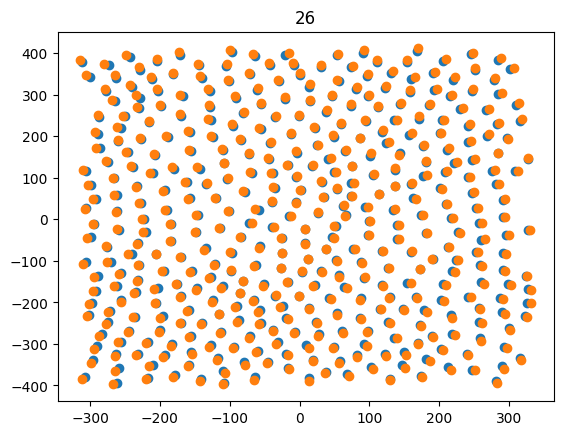

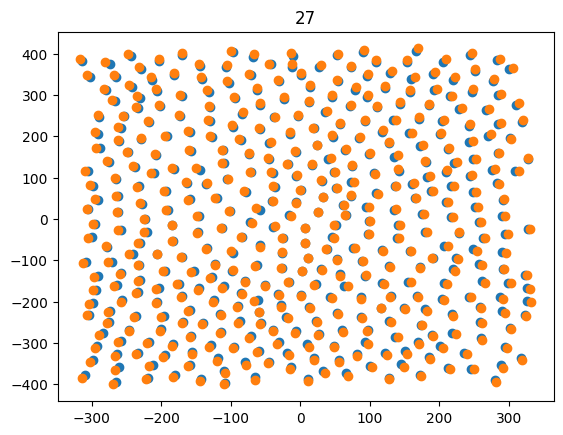

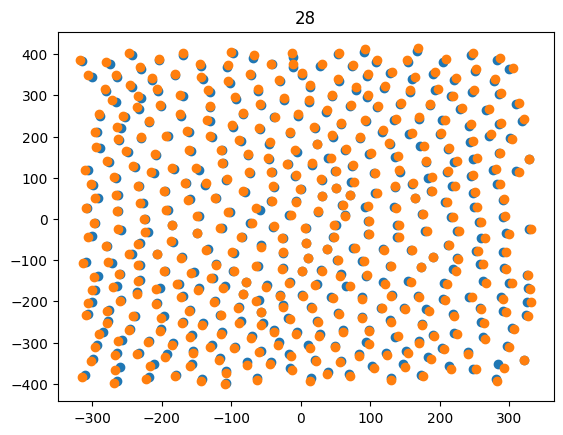

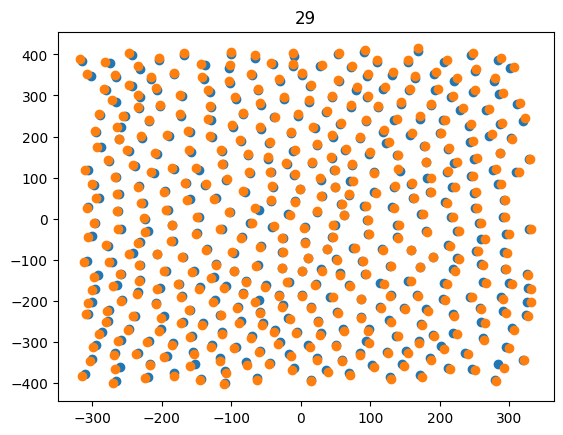

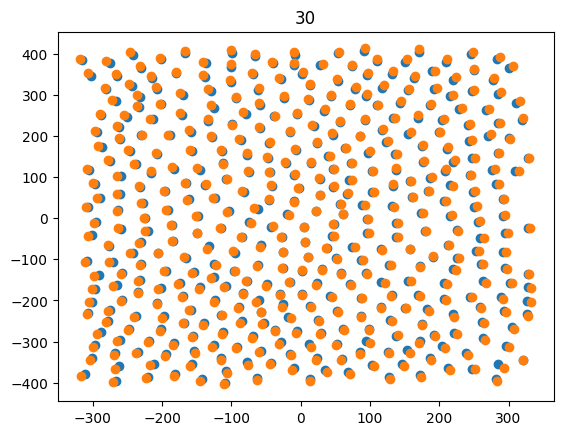

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\1987855659.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.loc[index_a]=t_id+1
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\1987855659.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.loc[index_b]=t_id+2
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\1987855659.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.

In [31]:
cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    scale_factor=0.75


    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    plt.scatter(cc[:,0], cc[:,1])
    plt.scatter(tm_cc[:,0], tm_cc[:,1])
    plt.title(str(i))
    plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


t_id=np.max(dat_df.track_id)
Nc_orig=t_id
for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]

    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
    dat_df.track_id.loc[index_a]=t_id+1
    track_b=[]
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
    dat_df.track_id.loc[index_b]=t_id+2
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=n_edges[n_edges.SPOT_SOURCE_ID==track_a[-1]].SPOT_TARGET_ID.iloc[0]
        t_b=n_edges[n_edges.SPOT_SOURCE_ID==track_b[-1]].SPOT_TARGET_ID.iloc[0]
        track_a.append(t_a)
        track_b.append(t_b)
        index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
        index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
        dat_df.track_id.loc[index_a]=t_id+1
        dat_df.track_id.loc[index_b]=t_id+2
    t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df.to_csv(save_folder+"/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled.csv",index=False)

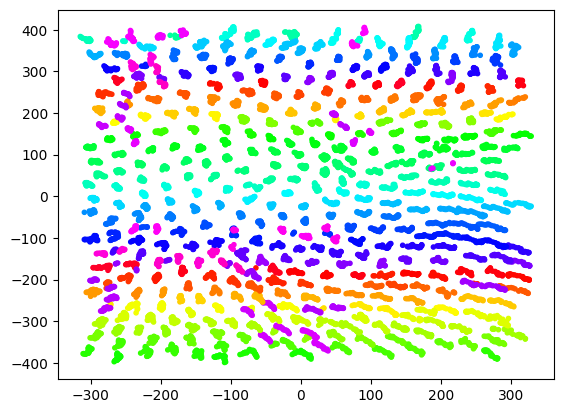

In [32]:
for i in range(30):
    plt.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))
plt.show()

In [34]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [35]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
div_cells=orig_cells[orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

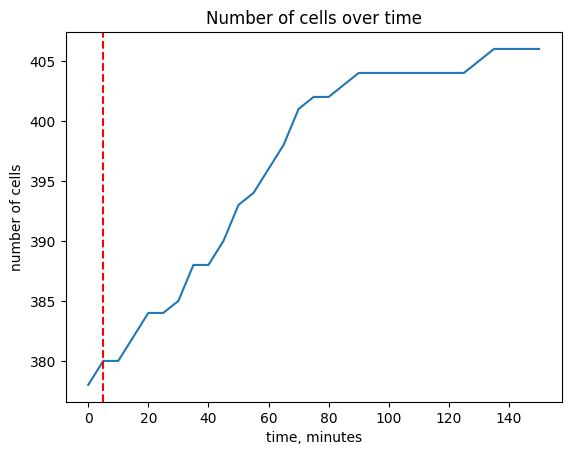

In [36]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(5, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

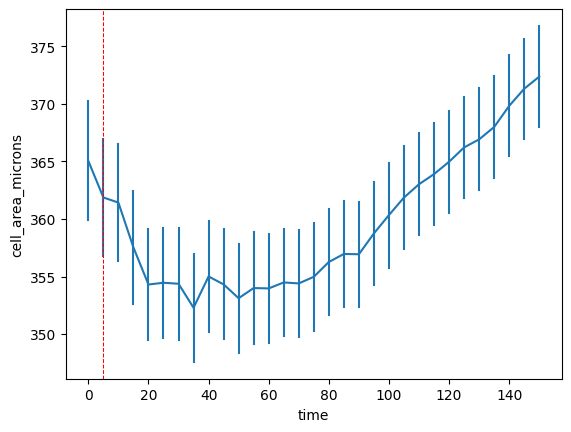

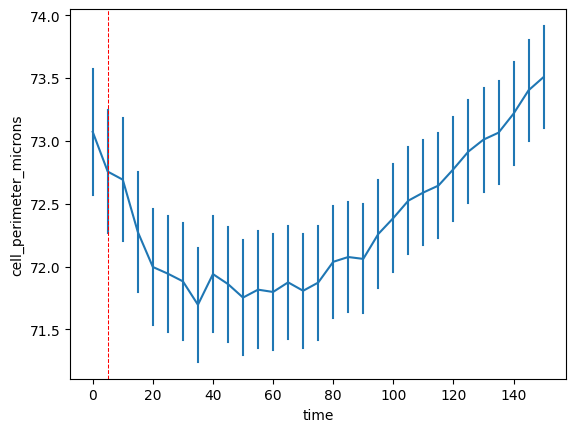

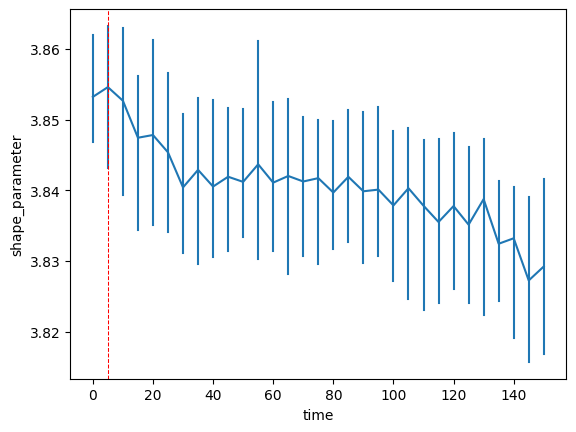

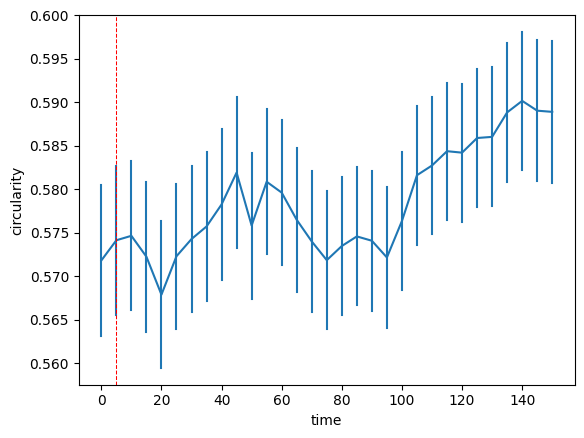

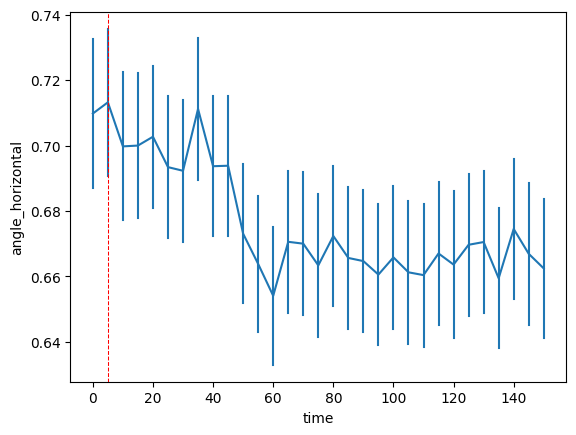

In [64]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

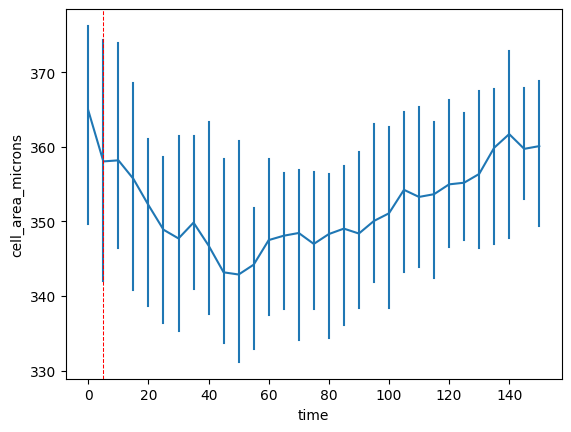

In [47]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', estimator='median')
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()

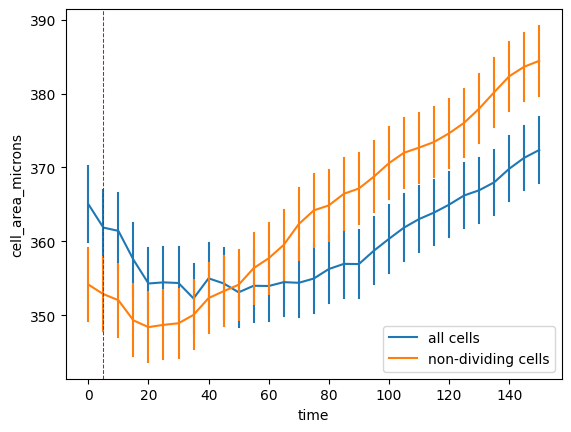

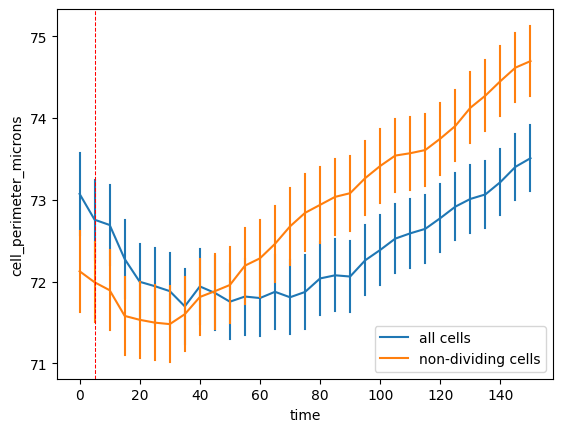

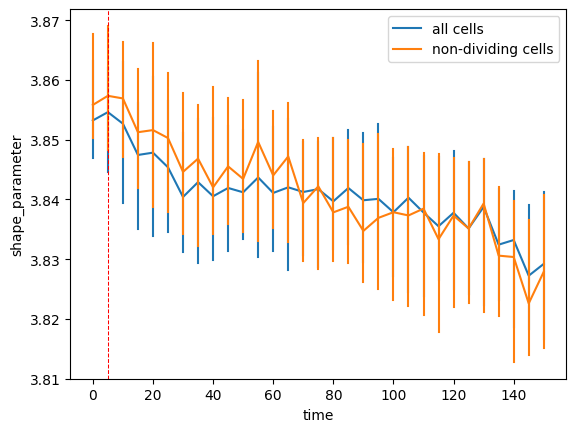

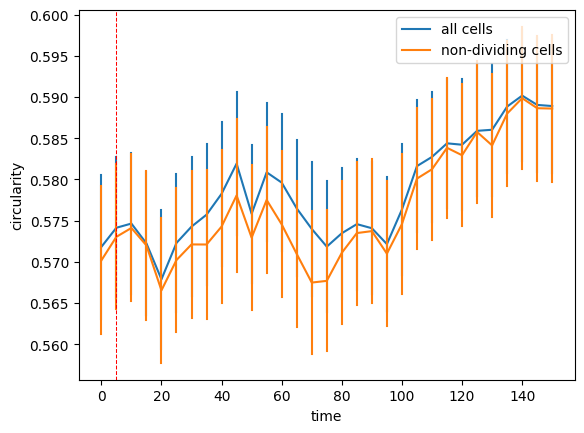

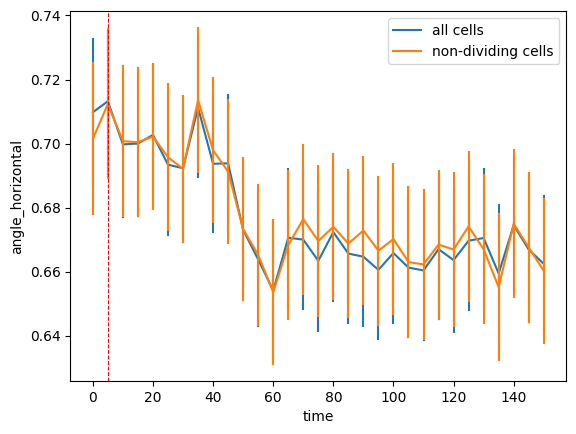

In [38]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

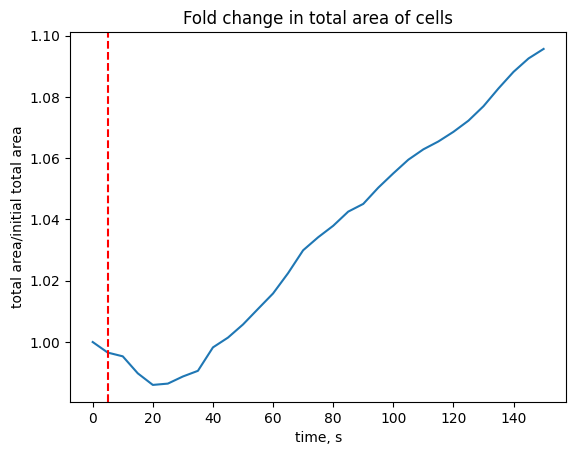

In [41]:
t=np.linspace(0, 150, 31)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(5, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\1999759422.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(t,dat_df.groupby('time').mean().cell_area_microns/dat_df[dat_df.time==0].mean().cell_area_microns)


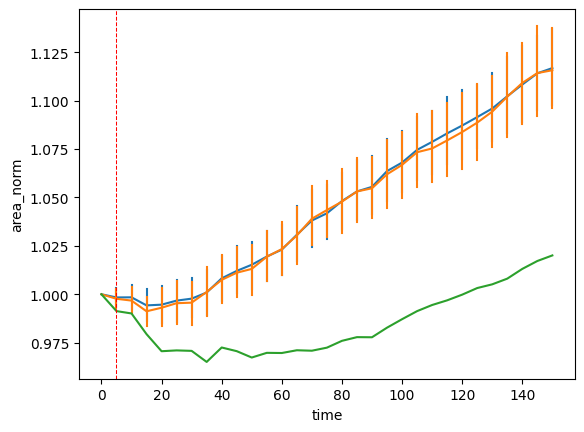

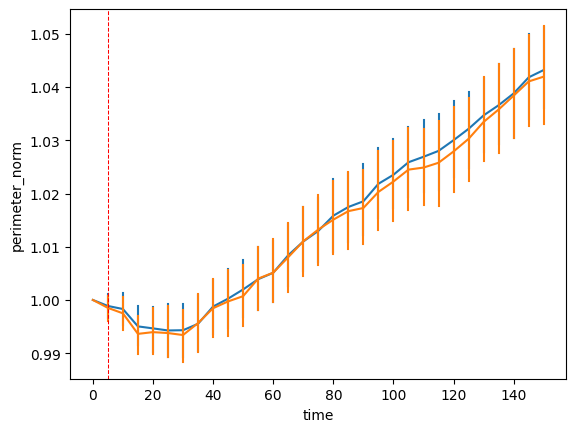

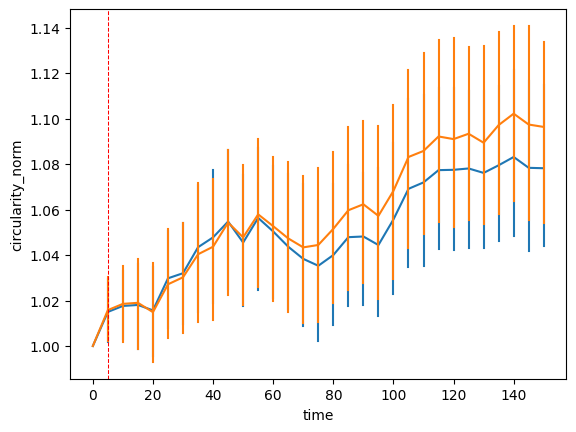

In [65]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars')
plt.plot(t,dat_df.groupby('time').mean().cell_area_microns/dat_df[dat_df.time==0].mean().cell_area_microns)
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars')

plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='circularity_norm', x='time',err_style='bars')

plt.axvline(5, c='r', linestyle='--', linewidth=0.75)
#plt.savefig(plot_dir+'/mean_circ_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\607017494.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\607017494.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_perimeter_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\607017494.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='circularity', element="step", palette=sns.husl_palette(3,l=.4

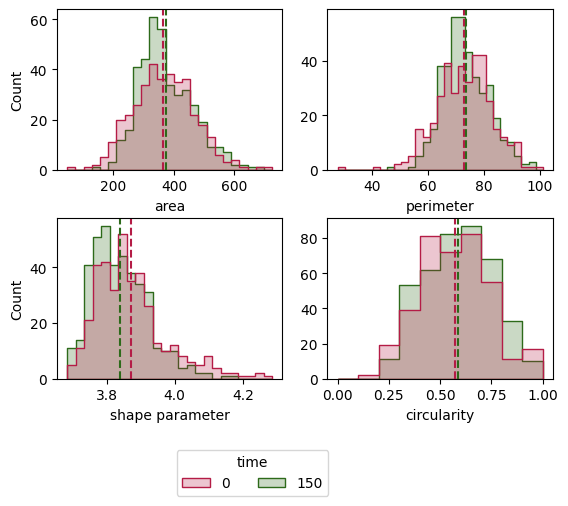

In [43]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==150].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_perimeter_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==150].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='circularity', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==150].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='shape_parameter', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==150].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

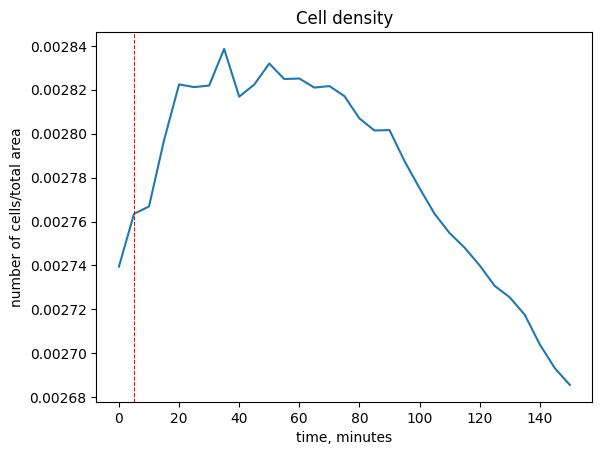

In [44]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(5, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

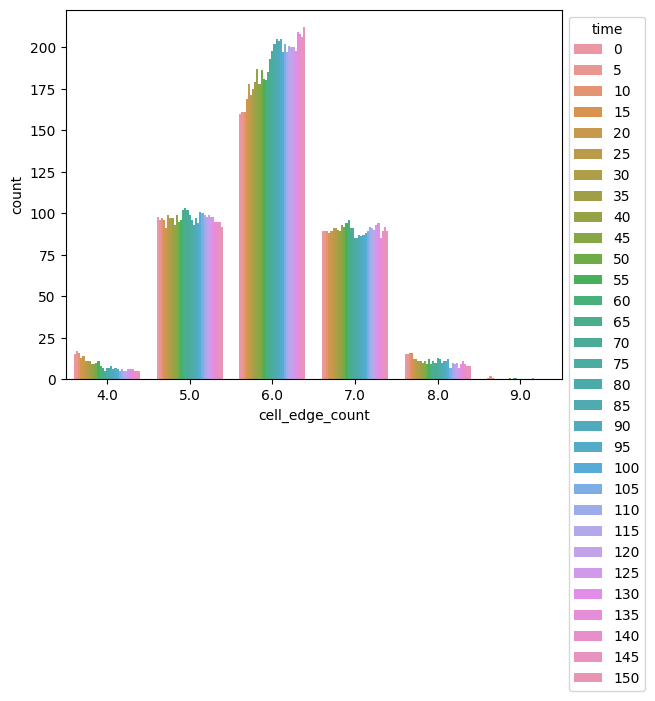

In [45]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

In [50]:
pa_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_*/*/Data/*_pref_area.txt'))
pref_area=[]
for file in pa_files:
    with open(file,"r") as f:
        pref_area.append(float(f.readline()))


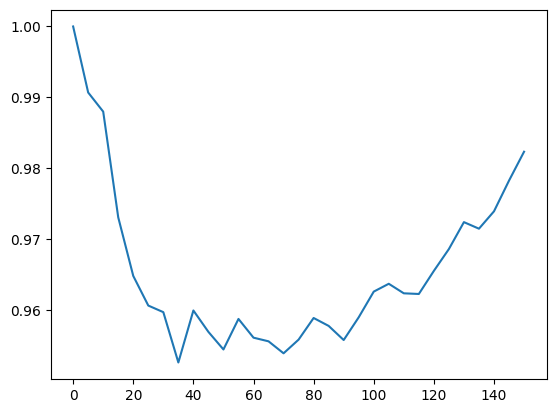

In [62]:
t=np.linspace(0, 150, 31)
plt.plot(t,np.array(pref_area)/np.array(pref_area)[0])

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_25668\827366255.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(t,dat_df.groupby('time').mean().cell_area_microns/dat_df[dat_df.time==0].mean().cell_area_microns)


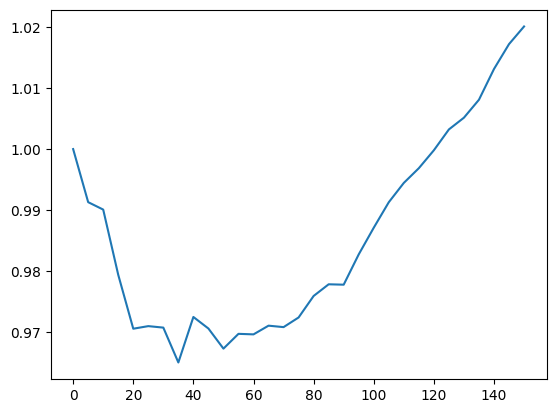

In [60]:
plt.plot(t,dat_df.groupby('time').mean().cell_area_microns/dat_df[dat_df.time==0].mean().cell_area_microns)

In [58]:
dat_df[dat_df.time==0].mean()

cell_id_old                        1.885000e+02
cell_perimeter_microns             7.307212e+01
cell_area_microns                  3.650362e+02
shape_parameter                    3.870712e+00
circularity                        5.718138e-01
cell_edge_count                    5.984127e+00
major_shape_axis_alignment_rads    1.568325e+00
cc_x                              -6.015177e-15
cc_y                               4.330927e-14
cell_id_new                        1.885000e+02
spot_id                            1.562879e+04
time                               0.000000e+00
tm_frame                           0.000000e+00
angle_horizontal                   7.097810e-01
area_norm                          1.000000e+00
perimeter_norm                     1.000000e+00
circularity_norm                   1.000000e+00
dtype: float64